# Generate glycine by trained model with data

## 1. Import modules

In [33]:
import nglview as nv
import ase
from ase.build import minimize_rotation_and_translation
from ase.io import read
from ase.io.trajectory import Trajectory

from loguru import logger
import numpy as np
from tqdm.auto import tqdm
import polars as pl
import math
import torch
from torch import Tensor
import matplotlib.pyplot as plt


from moldiv.molecule import ScoreTransformer
from moldiv.molecule.util import sample_free_com_batch
from moldiv.util import get_beta_i

## 2. Load trained model

Training have done by `train_glycine_with_data.py`.

In [3]:
model = ScoreTransformer()
with open("result_glycine/snapshot_iter_7030", "rb") as checkpoint_file:
    checkpoint = torch.load(checkpoint_file, map_location="cpu", weights_only=False)
model.load_state_dict(checkpoint["models"]["main"])
device = "cuda:0"
model = model.to(device)

For generation, gradient is not needed. Therefore, to reduce VRAM usage, one explicitly change no gradiant mode.

In [4]:
for param in model.parameters():
    param.requires_grad = False
model.eval()

ScoreTransformer(
  (atom_encoder): Embedding(9, 64, padding_idx=0)
  (time_encoder): SinusoidalPositionEmbeddings()
  (layers): ModuleList(
    (0-7): 8 x EncoderLayer(
      (self_attn): SelfMultiheadAttention(
        (in_proj): Linear(in_features=64, out_features=192, bias=True)
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): ResNetModule(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (act): SiLU()
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (final_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (gbf): GaussianLayer(
    (means): Embedding(1, 16)
    (stds): Embedding(1, 16)
    (mul): Embedding(81, 1)
    (bias): Embedding(81, 1)
  )
  (bias_proj): NonLinear(
    (layer1): Linear(in_features=16, out_fe

## 3. Set reference atom object

In [48]:
atoms = read("data/glycine/Glycine.mol")
atoms.positions = np.load("data/glycine/relaxed_positions_glycine.npy")
atoms.positions -= atoms.positions.mean(axis=1)[None, 3]
atoms_ref = atoms.copy()
n_atom = len(atoms)
nv.show_ase(atoms_ref)

NGLWidget()

## 4. Structure generation

### 4-1. SDE

At first, one generates structure by stochastic differential equation (SDE);

$$
\mathbf{x}_N \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

$$
\mathbf{x}_{i-1} = \frac{1}{\sqrt{1-\beta_i}}\left(\mathbf{x}_{i} + \beta_i \mathbf{s}^{\theta}
(\mathbf{x}_i, t_i)\right)
+ \mathcal{N}(\mathbf{0}, \beta_i\mathbf{I})
$$

In [14]:
def sample_sde(n_sample: int, model: ScoreTransformer, device: str = "cuda:0") -> Tensor:
    N = model.N
    h = 1 / N
    atoms = atoms_ref.copy()
    x_i = torch.randn(n_sample, n_atom, 3, device=device)
    x_i -= x_i.mean(dim=1, keepdim=True)
    Z_i = torch.tensor(atoms.get_atomic_numbers()).to(device).repeat(n_sample, 1)
    t_ones = torch.ones(n_sample, device=device)
    β = get_beta_i(N)
    atoms.positions = x_i[0].to("cpu").numpy()
    traj = Trajectory("data/glycine/reverse_sde_glycine.traj", "w", atoms)
    for i in tqdm(range(N, 0, -1)):
        t = i * h
        β_i = β[i]
        time = t * t_ones
        score, _ = model(x_i, Z_i, time)
        ϵ = sample_free_com_batch(x_i).to(x_i.device)
        x_i = (x_i + β_i * score) / math.sqrt(1 - β_i) + ϵ * math.sqrt(β_i)
        atoms.positions = x_i[0].to("cpu").numpy()
        minimize_rotation_and_translation(atoms_ref, atoms)
        traj.write(atoms)
    traj.close()
    return x_i.to("cpu").numpy()

In [15]:
generated_posi = sample_sde(500, model)

  0%|          | 0/500 [00:00<?, ?it/s]

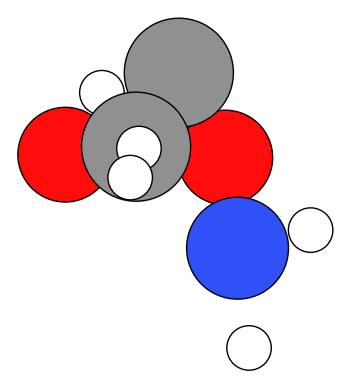

In [29]:
traj = read("data/glycine/reverse_sde_glycine.traj", ":")
ase.io.write("data/glycine/reverse_sde_glycine.gif", traj[::20])

![](data/glycine/reverse_sde_glycine.gif)

### 4.2 ODE

Second one generates structure by ordinary differential equation (ODE)

$$
\mathrm{d} \mathbf{x}_t=
-\frac{\beta_t}{2}\left[\mathbf{x}_t+\mathbf{s}^\theta\left(\mathbf{x}_t, t\right)\right] \mathrm{d} t
$$

Not that by setting argument `calc_prob=True`, we can estimate the sampled probability by following equation

$$
\log p^\theta
\left(\mathbf{x}_0\right)=
\log \mathcal{N}\left(\mathbf{x}_{t=\tau}^\theta\left(\mathbf{x}_0\right);\mathbf{0}, \mathbf{I}\right)
-\int_0^{\tau} \frac{\beta_t}{2} \nabla \cdot \mathbf{s}^\theta\left(\mathbf{x}_{t}^\theta\left(\mathbf{x}_0\right), t\right) \mathrm{d} t-
\frac{D}{2} \int_0^{\tau} \beta_t \mathrm{~d} t
$$

In [20]:
def get_dist(n_atom, dim, device):
    mu = torch.zeros(n_atom * dim - dim).to(device)
    sigma = torch.eye(n_atom * dim - dim).to(device)
    A = torch.eye(n_atom * dim).reshape(n_atom, dim, n_atom, dim)
    for i in range(dim):
        A[:, i, :, i] -= 1 / n_atom * torch.ones(n_atom, n_atom)
    A = A.reshape(n_atom * dim, n_atom * dim)
    torch.testing.assert_close(A.T @ A, A)
    val, vec = torch.linalg.eigh(A)
    Q = vec[:, 3:]
    torch.testing.assert_close(A, Q @ Q.T)
    dist = torch.distributions.MultivariateNormal(mu, sigma)
    return dist, Q.to(device)

In [46]:
def sample_ode(
    n_sample: int,
    model: torch.nn.Module,
    device: str = "cuda:0",
    calc_prob: bool = True,
) -> Tensor:
    N = model.N
    h = 1 / N
    atoms = atoms_ref.copy()
    dist, Q = get_dist(n_atom, 3, device)
    q_i = dist.sample((n_sample,))
    x_i = (dist.sample((n_sample,)) @ Q.T).reshape(n_sample, n_atom, 3)
    Z_i = torch.tensor(atoms.get_atomic_numbers()).to(device).repeat(n_sample, 1)
    t_ones = torch.ones(n_sample, device=device)
    dt = -1.0 / N
    β = get_beta_i(N)
    atoms.positions = x_i[0].to("cpu").numpy()
    traj = Trajectory("data/glycine/reverse_ode_glycine.traj", "w", atoms)
    prob = torch.zeros(n_sample, device=device)
    for i in tqdm(range(N, 0, -1)):
        t = i * h
        β_i = β[i]
        β_t = β_i / h
        time = t * t_ones
        score, _ = model(x_i, Z_i, time)
        x_i = x_i.detach() - (x_i.detach() + score.detach()) * β_t / 2.0 * dt
        if calc_prob:
            div = model.div(x_i, Z_i, time).detach()
            prob += (div + 27) * β_t / 2.0 * dt
        atoms.positions = x_i[0].detach().to("cpu").numpy()
        minimize_rotation_and_translation(atoms_ref, atoms)
        traj.write(atoms)
    traj.close()
    if calc_prob:
        prob += dist.log_prob(x_i.detach().view(n_sample, n_atom*3) @ Q)
    return x_i.detach().to("cpu").numpy(), prob.detach().to("cpu").numpy()

In [47]:
generated_posi, probs = sample_ode(10, model, calc_prob=True)

  0%|          | 0/500 [00:00<?, ?it/s]

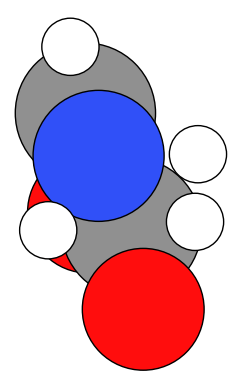

In [30]:
traj = read("data/glycine/reverse_ode_glycine.traj", ":")
ase.io.write("data/glycine/reverse_ode_glycine.gif", traj[::20])

![](data/glycine/reverse_ode_glycine.gif)

**Tips** : You can visualize trajectory by more elaborate software.

```python
ase.io.write("data/glycine/reverse_ode_glycine.xyz", traj)
```
and open `data/glycine/reverse_ode_glycine.xyz` by molecular viewer software such as [Avogadro2](https://www.openchemistry.org/projects/avogadro2/).



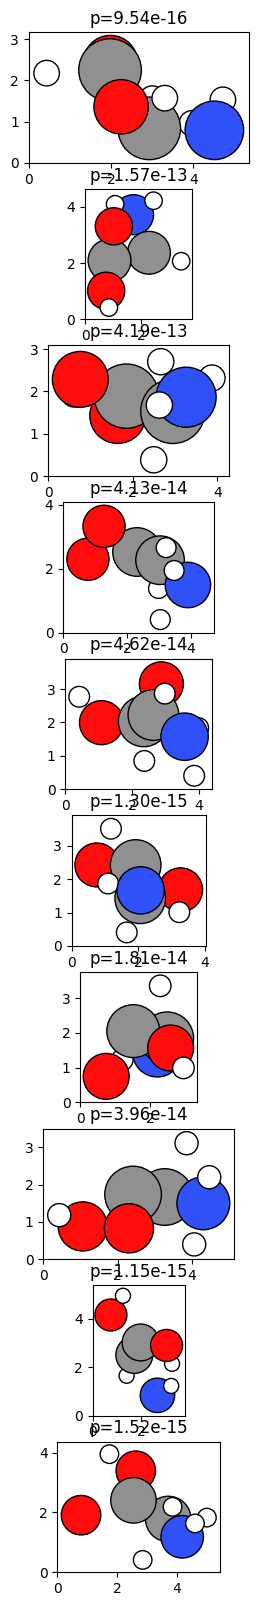

In [49]:
from ase.visualize.plot import plot_atoms
fig, axarr = plt.subplots(n:=len(generated_posi), 1, figsize=(10*n, 20))

atoms = atoms_ref.copy()
for i in range(len(generated_posi)):
    atoms.positions = generated_posi[i]
    ase.build.minimize_rotation_and_translation(atoms_ref, atoms)
    axarr[i].set_title(f"p={math.exp(probs[i]):.2e}")
    plot_atoms(atoms, axarr[i])